# 2️⃣Large DataSet of Generated Data - No preprocessing

- Combining the GPT-4mini and GPT-4o dataset, each contribute to 50% of the generated dataset

# Semi-Supervised Learning (Self-Training) reverse 🔀

* Semi-Supervised Learning combines labeled and unlabeled examples
* In self-Training, you could convert a Supervised Machine Learning algorithm to a semi-supervised one

### **Steps** ✨
1. Train supervised model using labeled data
2. Make predictions on unlabeled data using the model from the previous step
3. Take predictions satisfying probability threshold criteria and add them to the pseudo-labeled set
4. combine the labeled and pseudo-labeled data and train the next verion of the model
5. Make predictions on the remaining unlabeled data using this model of step 4
6. Take predictions satisfying the probability threshold and add them to an existing pseudo-labeled set

### **References:** 🔗
* https://www.kaggle.com/code/sasakitetsuya/semi-supervised-classification-on-a-text-dataset 
* https://scikit-learn.ru/example/semi-supervised-classification-on-a-text-dataset/


## Importing 

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/larger-dialects/Arabic_dialects_Larger.csv
/kaggle/input/generated-data4o/generated_data_4o.csv
/kaggle/input/generated-data/generated_data.csv
/kaggle/input/arabic-real-data-dialects/Arabic_dialects.csv


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
#==============================================different Linear classifiers
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.svm import LinearSVC
#=====================================================
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import re
import nltk
from nltk.corpus import stopwords

In [3]:
data1=pd.read_csv('/kaggle/input/generated-data/generated_data.csv')
data2=pd.read_csv('/kaggle/input/generated-data4o/generated_data_4o.csv')
# Combine the two datasets
data = pd.concat([data1, data2], ignore_index=True)



## Data Preprocessing

In [4]:
data.head()

,Unnamed: 0,Text,label
0,0,شرب الشاي مع النعناع، في وقت الاسترخاء.,Levantine
1,1,أمك شلونها، تحسنت صحتها بعد العملية؟,Iraqi
2,2,ذهبت لزيارة الأخت، وأحببت الجلسة معها.,Gulf
3,3,سمعت إنه فيه فرقة جديدة عم تتكون، بدها جماهير ...,Levantine
4,4,خطر لي، هل فعلا نقدر نحب جميعًا؟,Iraqi


In [5]:
data.columns

Index(['Unnamed: 0', 'Text', 'label'], dtype='object')

In [6]:
data.drop(['Unnamed: 0'], axis=1)

,Text,label
0,شرب الشاي مع النعناع، في وقت الاسترخاء.,Levantine
1,أمك شلونها، تحسنت صحتها بعد العملية؟,Iraqi
2,ذهبت لزيارة الأخت، وأحببت الجلسة معها.,Gulf
3,سمعت إنه فيه فرقة جديدة عم تتكون، بدها جماهير ...,Levantine
4,خطر لي، هل فعلا نقدر نحب جميعًا؟,Iraqi
...,...,...
12495,فين ممكن نلقاو فرص العمل فهاد المدينة؟,Maghrebi
12496,النهجة الجديدة بالمدارس شجعت كثير من الطلاب.,Iraqi
12497,الله يكمل على خير زواجكم.,Iraqi
12498,المسلسل التراجيدي العراقي نجح نجاح غير متوقع.,Iraqi


In [7]:
data.rename(columns={'Text': 'sent'},inplace=True, errors='raise')

In [8]:
label_counts = data['label'].value_counts()

In [9]:
label_counts

label
Levantine    2500
Iraqi        2500
Gulf         2500
Egyptian     2500
Maghrebi     2500
Name: count, dtype: int64

## Modeling

In [10]:
sdg_params = dict(alpha=1e-5, penalty='l2', loss='log')
arabic_stop_words = [
    "و", "في", "على", "إلى", "عن", "من", "مع", "كان", "التي", "الذي", "هذا",
    "هذه", "ذلك", "تلك", "كل", "كما", "قد", "لقد", "ليس", "هو", "هي", "هم",
    "هن", "أنا", "نحن", "انت", "انتِ", "لكن", "ثم", "أو", "أيضا", "هناك",
    "هنا", "قبل", "بعد"
]
vectorizer_params = dict(
    ngram_range=(1, 5),       # 1-5 grams
    min_df=5,                 # Ignore terms that appear in fewer than 5 documents
    max_df=0.8,               # Ignore terms that appear in more than 80% of documents
    analyzer='word',          # Tokenizes at the word level (common for Arabic text)
    stop_words=arabic_stop_words  # None by default, add Arabic stop words if needed
)

In [11]:
def pipeline_creation(type_of_supervision, i, count=False):
    # Define the list of classifiers and their names
    classifiers = [
        SGDClassifier(alpha=1e-5, penalty='l2', loss='log_loss', max_iter=1000),
        LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial'),
        CalibratedClassifierCV(LinearSVC(), method='isotonic'),
        CalibratedClassifierCV(PassiveAggressiveClassifier(max_iter=1000, C=0.5), method='isotonic'),
        MultinomialNB(alpha=0.5, fit_prior=True)
    ]
    
    classifier_names = [
        "SGDClassifier",
        "LogisticRegression",
        "Calibrated LinearSVC",
        "Calibrated PassiveAggressiveClassifier",
        "MultinomialNB"
    ]
    
    if count:
        return len(classifiers)
    
    # Select classifier based on type of supervision
    elif type_of_supervision == "supervised":
        pipeline = Pipeline([
            ('vect', CountVectorizer(**vectorizer_params)),
            ('tfidf', TfidfTransformer()),
            ('clf', classifiers[i])
        ])
        return pipeline, classifier_names[i]
    
    else:  # self-supervised
        st_pipeline = Pipeline([
            ('vect', CountVectorizer(**vectorizer_params)),
            ('tfidf', TfidfTransformer()),
            ('clf', SelfTrainingClassifier(classifiers[i], verbose=True))
        ])
        return st_pipeline, f"SelfTrainingClassifier with {classifier_names[i]}"


In [12]:
def eval_and_print_metrics(clf, X_train, y_train, X_test, y_test):
    print("Number of training samples:", len(X_train))
    print("Unlabeled samples in training set:",
          sum(1 for x in y_train if x == -1))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Micro-averaged F1 score on test set: "
          "%0.3f" % f1_score(y_test, y_pred, average='micro'))
    print("-" * 10)
    print()

In [13]:
# Main code to iterate over classifiers and display results
if __name__ == "__main__":
    results = []
    # Encode labels to handle text labels properly in sklearn classifiers
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(data.label)  # Fit on full set of labels

    X = data.sent
    y = y_encoded
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
    
    # Iterate over each classifier in the pipeline
    for i in range(pipeline_creation(0, 0, True)):

        print(100 * "*")
        
        # Supervised pipeline
        pipeline, classifier_name = pipeline_creation("supervised", i)
        print(f"Supervised training on 100% of the data using {classifier_name}:")
        eval_and_print_metrics(pipeline, X_train, y_train, X_test, y_test)
        
        # Decode labels to show original values in the classification report
        y_test_decoded = label_encoder.inverse_transform(y_test)
        y_pred = pipeline.predict(X_test)
        y_pred_decoded = label_encoder.inverse_transform(y_pred)
        report = classification_report(y_test_decoded, y_pred_decoded, output_dict=True)
        print(classification_report(y_test_decoded, y_pred_decoded))
        
        # Save results for Supervised 100%
        results.append({
            'Classifier': classifier_name,
            'Setting': 'Supervised 100%',
            'Accuracy': report['accuracy'],
            'F1-Score': report['macro avg']['f1-score']
        })

        # 20% labeled data setup
        y_mask = np.random.rand(len(y_train)) < 0.2  # Random mask for 20% of the data
        X_20, y_20 = map(list, zip(*((x, y) for x, y, m in zip(X_train, y_train, y_mask) if m)))
        print(f"Supervised training on 20% of the training data using {classifier_name}:")
        eval_and_print_metrics(pipeline, X_20, y_20, X_test, y_test)

        # Decode labels for partial training classification report
        y_pred_partial = pipeline.predict(X_test)
        y_pred_partial_decoded = label_encoder.inverse_transform(y_pred_partial)
        report_partial = classification_report(y_test_decoded, y_pred_partial_decoded, output_dict=True)
        print(classification_report(y_test_decoded, y_pred_partial_decoded))

        # Save results for Supervised 20%
        results.append({
            'Classifier': classifier_name,
            'Setting': 'Supervised 20%',
            'Accuracy': report_partial['accuracy'],
            'F1-Score': report_partial['macro avg']['f1-score']
        })

        # Semi-supervised pipeline with self-training
        st_pipeline, st_classifier_name = pipeline_creation("semi-supervised", i)
        y_train_semi = np.copy(y_train)  # Copy to modify labels for self-training
        y_train_semi[~y_mask] = -1  # Unlabel the non-masked subset

        print(f"{st_classifier_name} on 20% labeled training data (rest unlabeled):")
        eval_and_print_metrics(st_pipeline, X_train, y_train_semi, X_test, y_test)

        # Decode labels for semi-supervised classification report
        y_pred_semi = st_pipeline.predict(X_test)
        y_pred_semi_decoded = label_encoder.inverse_transform(y_pred_semi)
        report_semi = classification_report(y_test_decoded, y_pred_semi_decoded, output_dict=True)
        print(classification_report(y_test_decoded, y_pred_semi_decoded))

        # Save results for Self-Training
        results.append({
            'Classifier': classifier_name,
            'Setting': 'Self-Training',
            'Accuracy': report_semi['accuracy'],
            'F1-Score': report_semi['macro avg']['f1-score']
        })


****************************************************************************************************
Supervised training on 100% of the data using SGDClassifier:
Number of training samples: 9375
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.527
----------

              precision    recall  f1-score   support

    Egyptian       0.57      0.58      0.58       625
        Gulf       0.43      0.44      0.44       625
       Iraqi       0.46      0.47      0.47       625
   Levantine       0.48      0.43      0.45       625
    Maghrebi       0.69      0.70      0.70       625

    accuracy                           0.53      3125
   macro avg       0.53      0.53      0.53      3125
weighted avg       0.53      0.53      0.53      3125

Supervised training on 20% of the training data using SGDClassifier:
Number of training samples: 1832
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.397
----------

              precision    rec

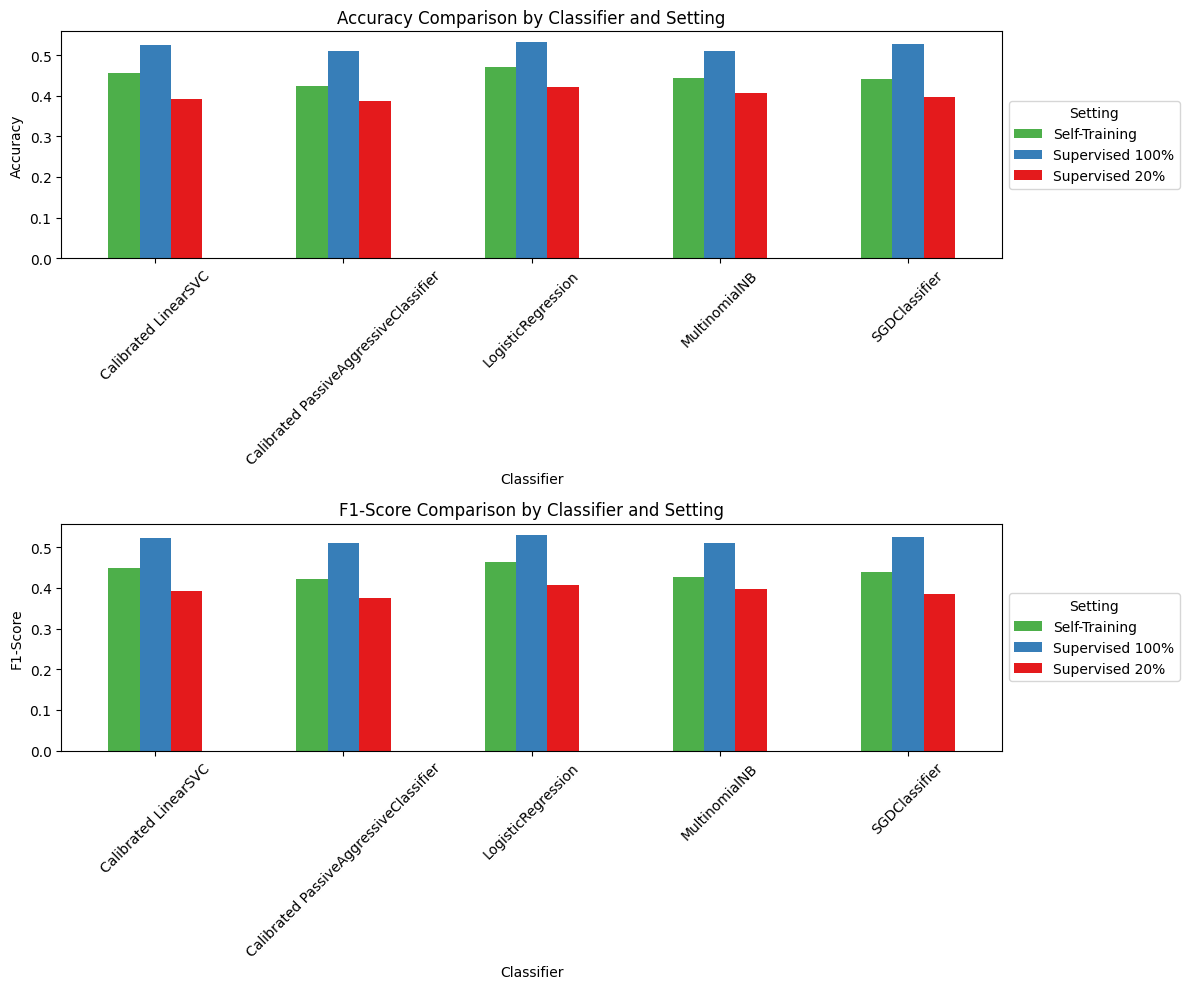

In [14]:

# Plotting
results_df = pd.DataFrame.from_dict(results)
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Accuracy plot
accuracy_df = results_df.pivot(index="Classifier", columns="Setting", values="Accuracy")
accuracy_df.plot(kind="bar", ax=axes[0], color=["#4daf4a", "#377eb8", "#e41a1c"])
axes[0].set_title("Accuracy Comparison by Classifier and Setting")
axes[0].set_ylabel("Accuracy")
axes[0].set_xlabel("Classifier")
axes[0].legend(title="Setting", loc="center left", bbox_to_anchor=(1.0, 0.5))
axes[0].tick_params(axis='x', rotation=45)

# F1-Score plot
f1_df = results_df.pivot(index="Classifier", columns="Setting", values="F1-Score")
f1_df.plot(kind="bar", ax=axes[1], color=["#4daf4a", "#377eb8", "#e41a1c"])
axes[1].set_title("F1-Score Comparison by Classifier and Setting")
axes[1].set_ylabel("F1-Score")
axes[1].set_xlabel("Classifier")
axes[1].legend(title="Setting", loc="center left", bbox_to_anchor=(1.0, 0.5))
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


In [15]:
# Pivot the DataFrame to reorganize for comparison
comparison_df = results_df.pivot(index="Classifier", columns="Setting", values=["Accuracy"])

# Display the formatted table
print("Comparison of Classifier Performance by Setting")
comparison_df

Comparison of Classifier Performance by Setting


Accuracy                  \
Setting                                Self-Training Supervised 100%   
Classifier                                                             
Calibrated LinearSVC                         0.45600         0.52576   
Calibrated PassiveAggressiveClassifier       0.42528         0.51104   
LogisticRegression                           0.47040         0.53216   
MultinomialNB                                0.44384         0.50912   
SGDClassifier                                0.44224         0.52704   

                                                       
Setting                                Supervised 20%  
Classifier                                             
Calibrated LinearSVC                          0.39232  
Calibrated PassiveAggressiveClassifier        0.38656  
LogisticRegression                            0.42048  
MultinomialNB                                 0.40768  
SGDClassifier                                 0.39744

In [16]:
# Pivot the DataFrame to reorganize for comparison
comparison_df = results_df.pivot(index="Classifier", columns="Setting", values=["F1-Score"])

# Display the formatted table
print("Comparison of Classifier Performance by Setting")
comparison_df

Comparison of Classifier Performance by Setting


F1-Score                  \
Setting                                Self-Training Supervised 100%   
Classifier                                                             
Calibrated LinearSVC                        0.450290        0.523723   
Calibrated PassiveAggressiveClassifier      0.421703        0.509718   
LogisticRegression                          0.463423        0.531162   
MultinomialNB                               0.426169        0.510373   
SGDClassifier                               0.438907        0.526199   

                                                       
Setting                                Supervised 20%  
Classifier                                             
Calibrated LinearSVC                         0.391916  
Calibrated PassiveAggressiveClassifier       0.376453  
LogisticRegression                           0.406362  
MultinomialNB                                0.396524  
SGDClassifier                                0.386136